# Current ML model data test
2025-01-23

It may be that the train and test data were mixed up, as there is definitely strong correlation beetween all the models. So use a proper splitting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.axes._axes import Axes as matplotlib_Axis
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn
import pickle
import re
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, auc

In [2]:
AF_prediction_path = Path("../ressources/AF_predictions").resolve()
AF_prediction_results = Path("../ressources/AF_predictions/AF_prediction_randomized_DMI_results.xlsx").resolve()
AF_prediction_metrics = Path("../ressources/AF_predictions/AF_metrics_all_structures.tsv").resolve()
AF_DMI_structures_folders = [Path("../ressources/AF_DMI_structures").resolve() / p for p in ['AF_DMI_structures1', 'AF_DMI_structures2', 'AF_DMI_structures3', "AF_DMI_mutated_structures"]]
AF_DDI_structures_path = Path("../ressources/AF_DDI_structures").resolve()
solved_DMI_structures_path = Path("../ressources/DMI_solved_structures_hydrogens").resolve()
solved_DDI_structures_path = Path("../ressources/DDI_solved_structures_hydrogens").resolve()

for p in [AF_prediction_results, AF_prediction_metrics, AF_DDI_structures_path, solved_DMI_structures_path, solved_DDI_structures_path] + AF_DMI_structures_folders:
    if not p.exists():
        print(f"{p} does not point to a valid path")

In [3]:
import hashlib

def md5hash(s: str): 
    return hashlib.md5(s.encode('utf-8')).hexdigest()

dataAF = pd.read_csv(AF_prediction_path / "data_af.csv")
dataAF.index = dataAF["prediction_name"] + "_" + dataAF["model_id"]
dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)
dataAF["structure_name_hash"] = dataAF["structure_name"].apply(md5hash)
print(dataAF.columns)
dataAF

Index(['project_name', 'prediction_name', 'run_id', 'chainA_length',
       'chainB_length', 'model_id', 'model_confidence',
       'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt',
       'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res',
       'num_res_res_contact', 'num_atom_atom_contact', 'RMSD_domain',
       'num_align_atoms_domain', 'align_score_domain', 'num_align_resi_domain',
       'RMSD_backbone_peptide', 'RMSD_all_atom_peptide', 'known_motif_plddt',
       'DockQ', 'iRMS', 'LRMS', 'Fnonnat', 'num_mutation_in_motif', 'label',
       'structure_name', 'file', 'hbonds', 'salt_bridges', 'buried_area',
       'min_distance', 'hydrophobic_interactions', 'structure_name_hash'],
      dtype='object')


,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
DEG_APCC_KENBOX_2_4GGD_ranked_0,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_0,0.887117,96.107999,77.495999,91.454999,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_0.pdb,9,0,613.651,6.063,0,f5b5923c8255df52d734f0b3d7e5344d
DEG_APCC_KENBOX_2_4GGD_ranked_1,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_1,0.871984,95.793846,73.986000,89.736111,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_1.pdb,9,0,580.310,6.083,0,f5b5923c8255df52d734f0b3d7e5344d
DEG_APCC_KENBOX_2_4GGD_ranked_2,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_2,0.760784,95.547501,57.906001,86.585239,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_2.pdb,10,0,662.104,6.072,3,f5b5923c8255df52d734f0b3d7e5344d
DEG_APCC_KENBOX_2_4GGD_ranked_3,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_3,0.413662,94.646667,21.510000,76.362500,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_3.pdb,2,0,398.498,5.417,0,f5b5923c8255df52d734f0b3d7e5344d
DEG_APCC_KENBOX_2_4GGD_ranked_4,AlphaFold_benchmark,DEG_APCC_KENBOX_2_4GGD,run37,312,5,ranked_4,0.359078,94.830001,19.753333,72.307001,...,known minimal,1,DEG_APCC_KENBOX_2_4GGD,ranked_4.pdb,2,0,323.304,5.092,9,f5b5923c8255df52d734f0b3d7e5344d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_0,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_0,0.298701,49.827778,73.161904,62.392307,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_0.pdb,7,3,1617.382,5.591,56,2364a28cae59cc5a9908f29e8da0ad81
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_1,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_1,0.246961,54.362000,76.415000,66.390909,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_1.pdb,3,0,791.256,6.373,7,2364a28cae59cc5a9908f29e8da0ad81
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_2,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_2,0.211579,52.651538,72.910908,61.937083,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_2.pdb,2,1,882.547,7.906,11,2364a28cae59cc5a9908f29e8da0ad81
D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74_ranked_3,AlphaFold_benchmark_DDI,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,run6,60,113,ranked_3,0.211144,50.398334,78.798751,66.627144,...,random minimal DDI,0,D1PF18773_PF00071_2X19.D2PF00009_PF01873_2D74,ranked_3.pdb,7,5,1020.896,4.628,44,2364a28cae59cc5a9908f29e8da0ad81


In [121]:
x = dataAF[dataAF["prediction_name"] == "PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177"]
x

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_0,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_0,0.731821,81.655001,86.288949,84.170573,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_0.pdb,4,2,1462.636,5.473,19,5194804629346701323
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_1,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_1,0.320172,60.186666,73.933501,68.042000,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_1.pdb,3,3,1315.682,4.998,21,5194804629346701323
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_2,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_2,0.261113,54.072222,87.745500,77.295172,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_2.pdb,5,1,961.536,5.986,4,5194804629346701323
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_3,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_3,0.249534,55.004000,67.416922,60.767143,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_3.pdb,6,5,1280.741,3.407,32,5194804629346701323
PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9_RESI177_ranked_4,AlphaFold_benchmark_DDI,PF18773_PF00071_2X19_B_RESI392_RESI451.A_RESI9...,run5,60,169,ranked_4,0.239689,55.814667,81.470715,68.200345,...,approved minimal DDI,1,PF18773_PF00071_2X19_B_resi392_resi451.A_resi9...,ranked_4.pdb,4,7,1092.702,3.521,39,5194804629346701323


In [8]:
X_columns = ["model_confidence", "chainA_intf_avg_plddt", "chainB_intf_avg_plddt", "intf_avg_plddt", "pDockQ", "iPAE", 
            "buried_area", "min_distance", "hbonds", "salt_bridges", "hydrophobic_interactions",
            "num_chainA_intf_res", "num_chainB_intf_res", "num_res_res_contact", "num_atom_atom_contact", "chainA_length", "chainB_length"]
dataAF_randomDMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "random minimal")]
dataAF_mutated1DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "1")]
dataAF_mutated2DMI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "known minimal", dataAF["num_mutation_in_motif"] == "2")]
dataAF_randomDDI = dataAF[np.logical_or(dataAF["num_mutation_in_motif"] == "approved minimal DDI", dataAF["num_mutation_in_motif"] == "random minimal DDI")]

dataAF_randomDMI = dataAF_randomDMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_mutated1DMI = dataAF_mutated1DMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_mutated2DMI = dataAF_mutated2DMI.sort_values(by=["structure_name_hash", "model_id"])
dataAF_randomDDI = dataAF_randomDDI.sort_values(by=["structure_name_hash", "model_id"])

print(dataAF_randomDMI.shape, dataAF_mutated1DMI.shape, dataAF_mutated2DMI.shape, dataAF_randomDDI.shape)


randomDMI_xy = train_test_split(dataAF_randomDMI[X_columns], dataAF_randomDMI["label"], test_size=0.2, random_state=2501, shuffle=True)
mutated1DMI_xy = train_test_split(dataAF_mutated1DMI[X_columns], dataAF_mutated1DMI["label"], test_size=0.2, random_state=2501, shuffle=False)
mutated2DMI_xy = train_test_split(dataAF_mutated2DMI[X_columns], dataAF_mutated2DMI["label"], test_size=0.2, random_state=2501, shuffle=False)
randomDDI_xy = train_test_split(dataAF_randomDDI[X_columns], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=False)

print("Random DMI: Train", randomDMI_xy[0].shape, "Test", randomDMI_xy[1].shape)
print("1 Mutation DMI: Train", mutated1DMI_xy[0].shape, "Test", mutated1DMI_xy[1].shape)
print("2 Mutation DMI: Train", mutated2DMI_xy[0].shape, "Test", mutated2DMI_xy[1].shape)
print("Random DDI: Train", randomDDI_xy[0].shape, "Test", randomDDI_xy[1].shape)


(1332, 37) (1332, 37) (1332, 37) (453, 37)
Random DMI: Train (1065, 17) Test (267, 17)
1 Mutation DMI: Train (1065, 17) Test (267, 17)
2 Mutation DMI: Train (1065, 17) Test (267, 17)
Random DDI: Train (362, 17) Test (91, 17)


In [9]:
display(dataAF_randomDMI)

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
LIG_RB_PABGROOVE_1_1N4M_ranked_0,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_0,0.908847,96.912000,87.598751,93.672609,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_0.pdb,8,6,939.231,5.873,62,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_1,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_1,0.906471,97.278667,85.092499,93.040000,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_1.pdb,6,5,933.856,5.894,62,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_2,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_2,0.901198,96.705624,86.317500,93.242916,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_2.pdb,7,6,961.618,5.914,63,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_3,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_3,0.896234,96.639334,84.940001,92.570000,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_3.pdb,7,5,949.634,5.869,64,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_4,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_4,0.882152,96.215332,80.497500,90.748260,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_4.pdb,5,5,940.080,5.950,56,007b0d28d0a636f9d01af50f10a2dba4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIG_PDZ_WMINUS1_1_1ZUB_ranked_0,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_0,0.912677,96.796249,92.852499,96.007499,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_0.pdb,6,0,844.052,4.089,68,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_1,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_1,0.905710,96.806666,92.350000,95.868421,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_1.pdb,6,0,867.506,4.031,66,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_2,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_2,0.901780,95.961333,91.317499,94.983684,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_2.pdb,6,0,858.773,3.939,65,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_3,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_3,0.896438,97.044000,89.705000,95.498948,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_3.pdb,6,0,865.000,4.348,70,fd8f1721425becbc4f2a78ffee4ecfb9


In [11]:
display(dataAF_randomDMI)

,project_name,prediction_name,run_id,chainA_length,chainB_length,model_id,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,...,num_mutation_in_motif,label,structure_name,file,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions,structure_name_hash
LIG_RB_PABGROOVE_1_1N4M_ranked_0,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_0,0.908847,96.912000,87.598751,93.672609,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_0.pdb,8,6,939.231,5.873,62,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_1,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_1,0.906471,97.278667,85.092499,93.040000,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_1.pdb,6,5,933.856,5.894,62,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_2,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_2,0.901198,96.705624,86.317500,93.242916,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_2.pdb,7,6,961.618,5.914,63,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_3,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_3,0.896234,96.639334,84.940001,92.570000,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_3.pdb,7,5,949.634,5.869,64,007b0d28d0a636f9d01af50f10a2dba4
LIG_RB_PABGROOVE_1_1N4M_ranked_4,AlphaFold_benchmark,LIG_RB_PABGROOVE_1_1N4M,run37,202,8,ranked_4,0.882152,96.215332,80.497500,90.748260,...,known minimal,1,LIG_Rb_pABgroove_1_1N4M,ranked_4.pdb,5,5,940.080,5.950,56,007b0d28d0a636f9d01af50f10a2dba4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIG_PDZ_WMINUS1_1_1ZUB_ranked_0,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_0,0.912677,96.796249,92.852499,96.007499,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_0.pdb,6,0,844.052,4.089,68,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_1,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_1,0.905710,96.806666,92.350000,95.868421,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_1.pdb,6,0,867.506,4.031,66,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_2,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_2,0.901780,95.961333,91.317499,94.983684,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_2.pdb,6,0,858.773,3.939,65,fd8f1721425becbc4f2a78ffee4ecfb9
LIG_PDZ_WMINUS1_1_1ZUB_ranked_3,AlphaFold_benchmark,LIG_PDZ_WMINUS1_1_1ZUB,run37,89,4,ranked_3,0.896438,97.044000,89.705000,95.498948,...,known minimal,1,LIG_PDZ_Wminus1_1_1ZUB,ranked_3.pdb,6,0,865.000,4.348,70,fd8f1721425becbc4f2a78ffee4ecfb9


In [64]:
x = mutated1DMI_xy[2]
x

LIG_PCNA_TLS_4_2ZVL_KHTLDIFF.KHTDDIFF_ranked_0    0
LIG_PCNA_TLS_4_2ZVL_KHTLDIFF.KHTDDIFF_ranked_1    0
LIG_PCNA_TLS_4_2ZVL_KHTLDIFF.KHTDDIFF_ranked_2    0
LIG_PCNA_TLS_4_2ZVL_KHTLDIFF.KHTDDIFF_ranked_3    0
LIG_PCNA_TLS_4_2ZVL_KHTLDIFF.KHTDDIFF_ranked_4    0
                                                 ..
LIG_WD40_WDR5_WIN_1_3UVK_ranked_3                 1
LIG_WD40_WDR5_WIN_1_3UVK_ranked_4                 1
LIG_LIR_GEN_1_2L8J_ranked_0                       1
LIG_LIR_GEN_1_2L8J_ranked_1                       1
LIG_LIR_GEN_1_2L8J_ranked_2                       1
Name: label, Length: 1065, dtype: int64

In [6]:
#rf_param_grid_randomDMI = {
#    "criterion": ["gini", "entropy", "log_loss"],
#    "n_estimators": [150, 200, 250, 300],
#    "min_samples_split": [6, 8, 10], 
#    "min_samples_leaf": [4],
#    "max_features": [6]
#}
rf_param_grid_randomDMI = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [150, 200, 250],
    "min_samples_split": [6, 8, 10], 
    "min_samples_leaf": [4],
    "min_samples_leaf": [5,6],
}
rf_param_grid_randomDMI = {
    "criterion": ["log_loss"],
    "n_estimators": [150, 200, 250],
    "min_samples_leaf": [5,6]
}

rf_randomDMI = RandomForestClassifier(random_state=2501)
random_search_randomDMI = RandomizedSearchCV(n_iter=10, estimator=rf_randomDMI, param_distributions=rf_param_grid_randomDMI, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_randomDMI.fit(randomDMI_xy[0], randomDMI_xy[2])
rf_best_randomDMI = random_search_randomDMI.best_estimator_
print("Score", accuracy_score(randomDMI_xy[3], rf_best_randomDMI.predict(randomDMI_xy[1])))
print("ROC auc score:", roc_auc_score(randomDMI_xy[3], rf_best_randomDMI.predict_proba(randomDMI_xy[1])[:,1]))
rf_best_randomDMI

c:\Users\abril\dev\programs\minconda\envs\bachelor01\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Score 0.7415730337078652
ROC auc score: 0.7699775533108867


RandomForestClassifier(criterion='log_loss', min_samples_leaf=5,
                       n_estimators=200, random_state=2501)

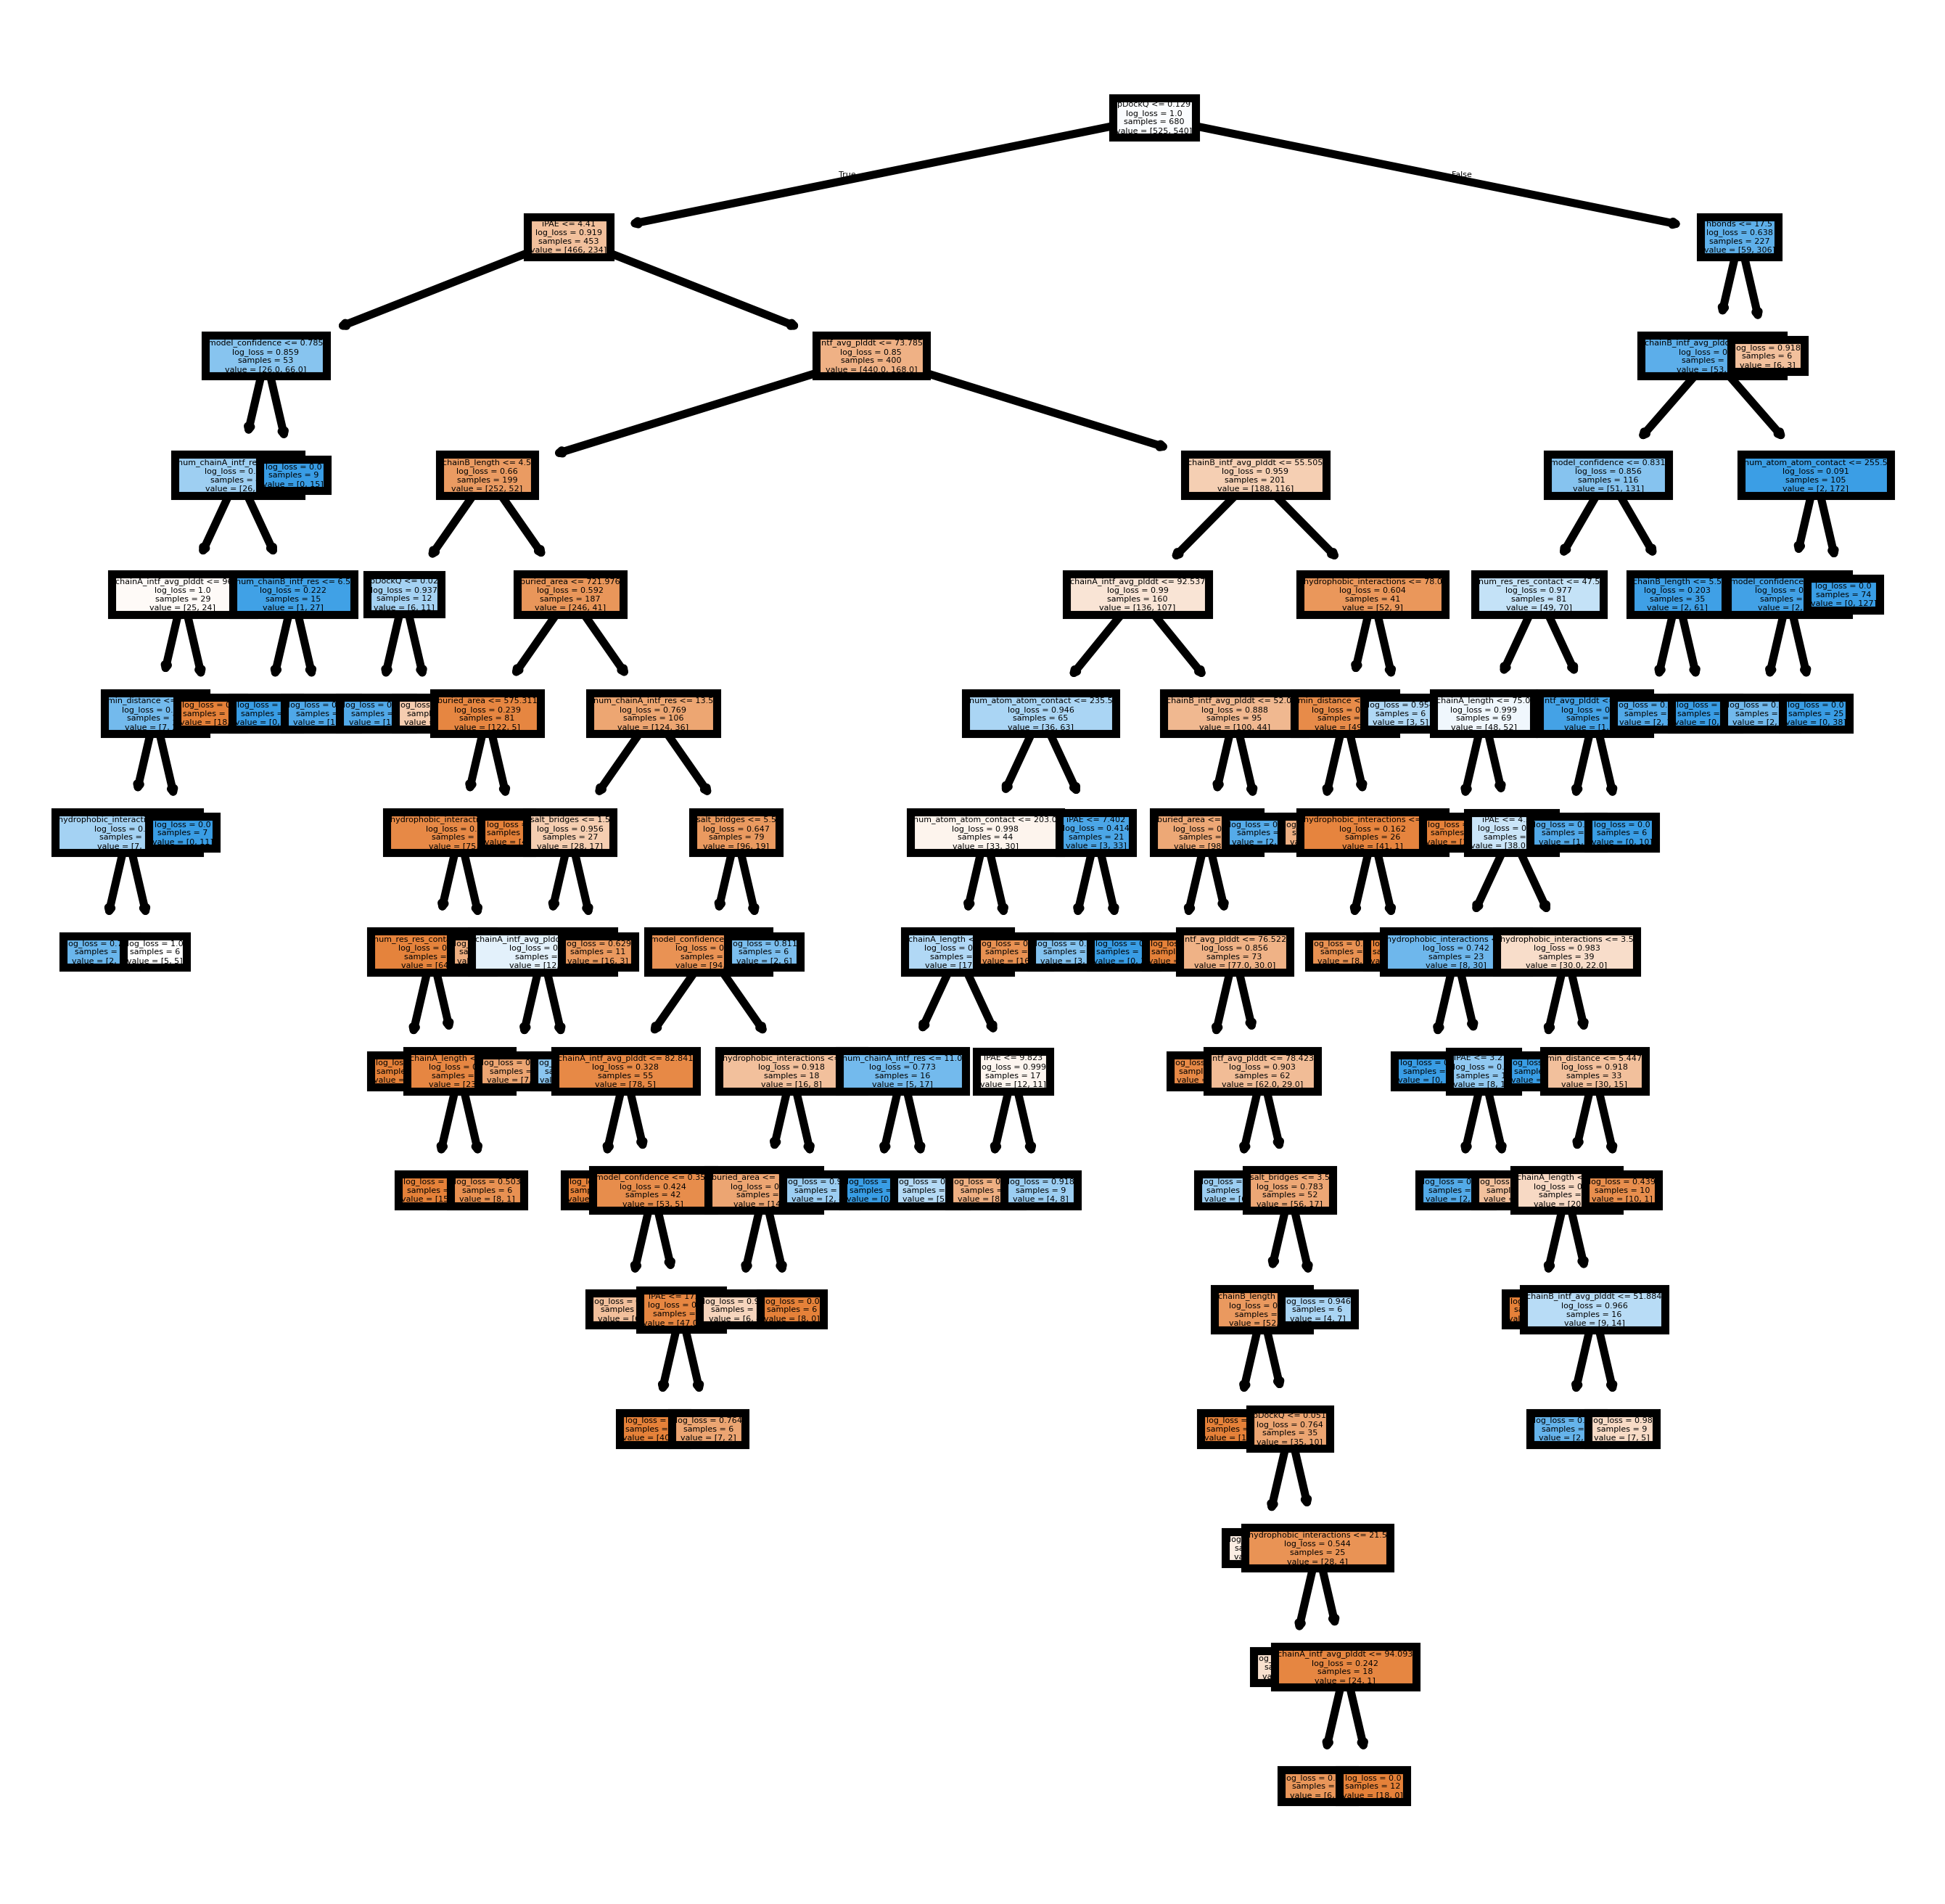

In [88]:
import sklearn.tree


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
sklearn.tree.plot_tree(rf_best_randomDMI.estimators_[1], feature_names=X_columns, filled=True)
plt.show()


In [10]:
# New model with gradient boosting

from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold


param_grid = {
    'rf__n_estimators': [150, 200, 250],         # Slightly increase n_estimators for Random Forest
    'rf__max_depth': [15, 20, None],             # Relax max_depth slightly
    'rf__min_samples_split': [6, 8, 10],         # Maintain higher min_samples_split for better generalization
    'rf__min_samples_leaf': [4, 5],              # Keep min_samples_leaf higher, but relax a bit

    'gb__n_estimators': [100, 150],              # Slightly fewer boosting iterations for GB to avoid overfitting
    'gb__learning_rate': [0.01, 0.02, 0.05],     # Fine-tune smaller learning rate for smoother updates
    'gb__max_depth': [3, 4, 5],                  # Keep the max depth smaller
    'gb__min_samples_split': [6, 8],             # Allow larger samples for splitting to generalize better
    'gb__min_samples_leaf': [4, 5],              # Keep larger leaves for GB
    'gb__subsample': [0.8, 0.9]    
}
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, validation_fraction=0.1)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('gb', gb_model)
], voting='soft')
# Stratified K-Fold for better validation
stratified_kfold = StratifiedKFold(n_splits=10)
random_search_randomDMI = RandomizedSearchCV(estimator=voting_clf, param_distributions=param_grid, cv=stratified_kfold,
                                   n_iter=20, scoring='accuracy', n_jobs=-1, verbose=2)
random_search_randomDMI.fit(randomDMI_xy[0], randomDMI_xy[2])
rf_best_randomDMI = random_search_randomDMI.best_estimator_
print("Score", accuracy_score(randomDMI_xy[3], rf_best_randomDMI.predict(randomDMI_xy[1])))
print("ROC auc score:", roc_auc_score(randomDMI_xy[3], rf_best_randomDMI.predict_proba(randomDMI_xy[1])[:,1]))
rf_best_randomDMI

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Score 0.8052434456928839
ROC auc score: 0.9054539333408147


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_leaf=4,
                                                     min_samples_split=6,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=5,
                                                         min_samples_leaf=4,
                                                         min_samples_split=6,
                                                         n_estimators=150,
                                                         n_iter_no_change=5,
                                                         random_state=42,
                                                         subsample=0.9))],
                 voting='soft')

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, validation_fraction=0.1)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('gb', gb_model)
], voting='soft')
# Stratified K-Fold for better validation
stratified_kfold = StratifiedKFold(n_splits=10)
random_search_randomDDI = RandomizedSearchCV(estimator=voting_clf, param_distributions=param_grid, cv=stratified_kfold,
                                   n_iter=20, scoring='accuracy', n_jobs=-1, verbose=2)
random_search_randomDDI.fit(randomDDI_xy[0], randomDDI_xy[2])
rf_best_randomDDI = random_search_randomDDI.best_estimator_
print("Score", accuracy_score(randomDDI_xy[3], rf_best_randomDDI.predict(randomDDI_xy[1])))
print("ROC auc score:", roc_auc_score(randomDDI_xy[3], rf_best_randomDDI.predict_proba(randomDDI_xy[1])[:,1]))
rf_best_randomDDI

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Score 0.6043956043956044
ROC auc score: 0.5154589371980677


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_leaf=4,
                                                     min_samples_split=8,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         min_samples_leaf=4,
                                                         min_samples_split=6,
                                                         n_estimators=150,
                                                         n_iter_no_change=5,
                                                         random_state=42,
                                                         subsample=0.8))],
                 voting='soft')

In [93]:
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, validation_fraction=0.1)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('gb', gb_model)
], voting='soft')
# Stratified K-Fold for better validation
stratified_kfold = StratifiedKFold(n_splits=10)
random_search_mutated1DMI = RandomizedSearchCV(estimator=voting_clf, param_distributions=param_grid, cv=stratified_kfold,
                                   n_iter=20, scoring='accuracy', n_jobs=-1, verbose=2)
random_search_mutated1DMI.fit(mutated1DMI_xy[0], mutated1DMI_xy[2])
rf_best_mutated1DMI = random_search_mutated1DMI.best_estimator_
print("Score", accuracy_score(mutated1DMI_xy[3], rf_best_mutated1DMI.predict(mutated1DMI_xy[1])))
print("ROC auc score:", roc_auc_score(mutated1DMI_xy[3], rf_best_mutated1DMI.predict_proba(mutated1DMI_xy[1])[:,1]))
rf_best_mutated1DMI

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Score 0.5093632958801498
ROC auc score: 0.5115103874227962


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(min_samples_leaf=5,
                                                     min_samples_split=6,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         min_samples_leaf=5,
                                                         min_samples_split=6,
                                                         n_iter_no_change=5,
                                                         random_state=42,
                                                         subsample=0.8))],
                 voting='soft')

In [94]:
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, n_iter_no_change=5, validation_fraction=0.1)
voting_clf = VotingClassifier(estimators=[
    ('rf', rf_model), 
    ('gb', gb_model)
], voting='soft')
# Stratified K-Fold for better validation
stratified_kfold = StratifiedKFold(n_splits=10)
random_search_mutated2DMI = RandomizedSearchCV(estimator=voting_clf, param_distributions=param_grid, cv=stratified_kfold,
                                   n_iter=20, scoring='accuracy', n_jobs=-1, verbose=2)
random_search_mutated2DMI.fit(mutated2DMI_xy[0], mutated2DMI_xy[2])
rf_best_mutated2DMI = random_search_mutated2DMI.best_estimator_
print("Score", accuracy_score(mutated2DMI_xy[3], rf_best_mutated2DMI.predict(mutated2DMI_xy[1])))
print("ROC auc score:", roc_auc_score(mutated2DMI_xy[3], rf_best_mutated2DMI.predict_proba(mutated2DMI_xy[1])[:,1]))
rf_best_mutated2DMI

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Score 0.6853932584269663
ROC auc score: 0.7259718309859154


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=15,
                                                     min_samples_leaf=5,
                                                     min_samples_split=8,
                                                     n_estimators=250,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         min_samples_leaf=5,
                                                         min_samples_split=8,
                                                         n_iter_no_change=5,
                                                         random_state=42,
                                                         subsample=0.8))],
                 voting='soft')

In [159]:
rf_param_grid_randomDDI = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [150, 200, 250],
    "max_depth": [4,6],
    "max_features": [4,5,6,8]
}

rf_randomDDI = RandomForestClassifier(random_state=2501)
random_search_randomDDI = RandomizedSearchCV(n_iter=10, estimator=rf_randomDDI, param_distributions=rf_param_grid_randomDDI, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_randomDDI.fit(randomDDI_xy[0], randomDDI_xy[2])
rf_best_randomDDI = random_search_randomDDI.best_estimator_
print("Score", accuracy_score(randomDDI_xy[3], rf_best_randomDDI.predict(randomDDI_xy[1])))
print("ROC auc score:", roc_auc_score(randomDDI_xy[3], rf_best_randomDDI.predict_proba(randomDDI_xy[1])[:,1]))
rf_best_randomDDI

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score 0.6153846153846154
ROC auc score: 0.49227053140096616


RandomForestClassifier(criterion='log_loss', max_depth=4, max_features=6,
                       n_estimators=150, random_state=2501)

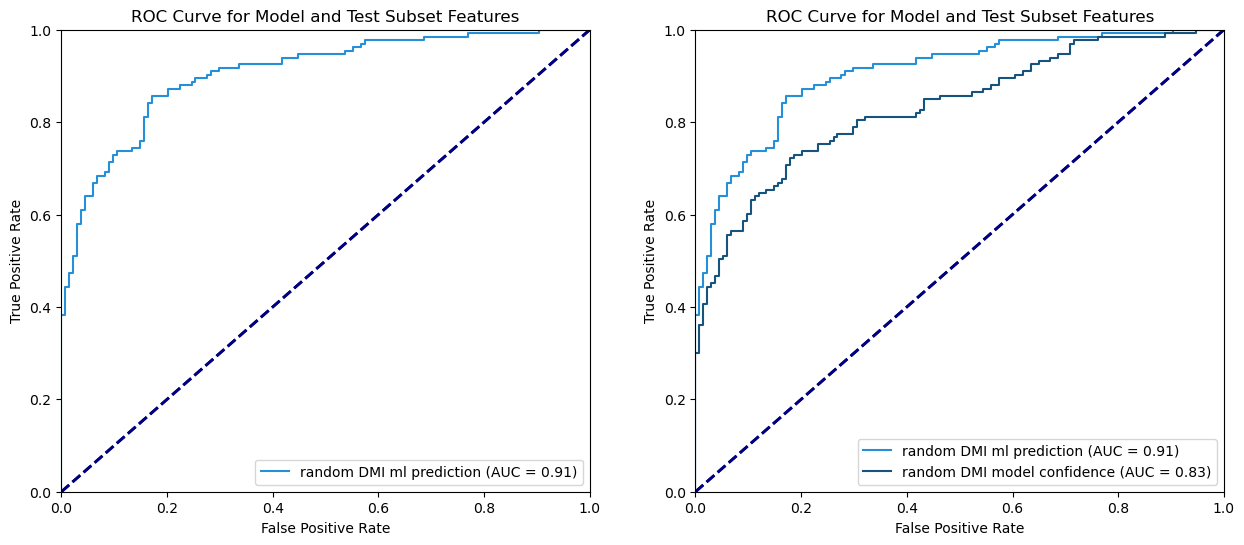

In [11]:
result_array = [
   ("random DMI", rf_best_randomDMI, randomDMI_xy),
   #("1 mutation DMI", rf_best_mutated1DMI, mutated1DMI_xy),
   #("2 mutation DMI", rf_best_mutated2DMI, mutated2DMI_xy),
   #("random DDI", rf_best_randomDDI, randomDDI_xy)
]

# Roc Curve
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax1, ax2 = axes
for name, model, xy in result_array:
   y_preda = model.predict_proba(xy[1])
    
   roc_conf_X, roc_conf_Y, _ = roc_curve(xy[3], xy[1]["model_confidence"])
   roc_conf = auc(roc_conf_X, roc_conf_Y)
   roc_model_X, roc_model_Y, _ = roc_curve(xy[3], y_preda[:, 1])
   roc_model = auc(roc_model_X, roc_model_Y)

   _line2D = ax1.plot(roc_model_X, roc_model_Y, label=f"{name} ml prediction (AUC = {roc_model:.2f})")[0]
   c = np.array(colors.to_rgb(_line2D.get_color()))
   c1 = np.clip(1.2*c, a_max=1, a_min=None)
   c2 = 0.7*c
   _line2D.set_color(c1)
   ax2.plot(roc_model_X, roc_model_Y, label=f"{name} ml prediction (AUC = {roc_model:.2f})", color=c1)
   
   ax2.plot(roc_conf_X, roc_conf_Y, label=f"{name} model confidence (AUC = {roc_conf:.2f})", color=c2)
for ax in [ax1, ax2]:   
   ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   ax.set_xlim([0,1])
   ax.set_ylim([0,1])
   ax.set_xlabel('False Positive Rate')
   ax.set_ylabel('True Positive Rate')
   ax.set_title("ROC Curve for Model and Test Subset Features")
   ax.legend(loc="lower right")
plt.show()

In [116]:
y_preda = rf_best_randomDDI.predict_proba(randomDDI_xy[1])
y_pred = rf_best_randomDDI.predict(randomDDI_xy[1])
result = randomDDI_xy[1].copy()
result["positive"] = y_preda[:, 0]
result["negative"] = y_preda[:, 1]
result["prediction"] = y_pred
result["label"] = randomDDI_xy[3]
result

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,...,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length,positive,negative,prediction,label
D1PF04824_PF02463_1W1W.D2PF05064_PF13874_5C3L_ranked_4,0.111861,62.247143,71.786333,65.869620,0.301608,27.788378,3844.293,3.320,20,1,...,49,30,161,2059,65,133,0.443334,0.556666,1,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_0,0.333336,76.316363,54.741666,68.701764,0.021149,18.937864,663.690,5.666,3,5,...,11,6,14,103,545,157,0.605501,0.394499,0,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_1,0.287331,63.253334,70.560001,67.428573,0.021994,23.096992,213.962,6.008,0,0,...,3,4,5,19,545,157,0.602335,0.397665,0,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_2,0.284513,47.334999,63.520002,55.427501,0.018633,25.572483,189.136,7.780,1,0,...,2,2,3,42,545,157,0.647073,0.352927,0,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_3,0.279699,70.459999,57.746666,64.103333,0.019180,23.796291,219.700,6.103,0,0,...,3,3,3,20,545,157,0.617764,0.382236,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_0,0.692902,89.367894,88.376000,88.930294,0.192467,2.873899,1345.952,4.643,5,5,...,19,15,40,269,81,48,0.146201,0.853799,1,1
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_1,0.569047,83.287778,82.211429,82.816875,0.127697,4.397363,1190.304,4.655,6,8,...,18,14,36,265,81,48,0.446104,0.553896,1,1
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_2,0.280830,84.277143,73.468751,78.512667,0.045730,10.934839,669.216,5.935,4,4,...,7,8,16,166,81,48,0.728480,0.271520,0,1
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_3,0.270853,90.825001,79.733001,83.892501,0.057758,15.862081,698.903,4.868,5,6,...,6,10,17,182,81,48,0.795698,0.204302,0,1


In [114]:
_merged 

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,buried_area,min_distance,hbonds,salt_bridges,hydrophobic_interactions,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,chainA_length,chainB_length,positive,negative,prediction
D1PF04824_PF02463_1W1W.D2PF05064_PF13874_5C3L_ranked_4,0.111861,62.247143,71.786333,65.869620,0.301608,27.788378,3844.293,3.320,20,1,296,49,30,161,2059,65,133,0.443334,0.556666,1
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_0,0.333336,76.316363,54.741666,68.701764,0.021149,18.937864,663.690,5.666,3,5,0,11,6,14,103,545,157,0.605501,0.394499,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_1,0.287331,63.253334,70.560001,67.428573,0.021994,23.096992,213.962,6.008,0,0,2,3,4,5,19,545,157,0.602335,0.397665,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_2,0.284513,47.334999,63.520002,55.427501,0.018633,25.572483,189.136,7.780,1,0,0,2,2,3,42,545,157,0.647073,0.352927,0
D1PF06857_PF16957_5VJ1.D2PF06991_PF08082_7AAV_ranked_3,0.279699,70.459999,57.746666,64.103333,0.019180,23.796291,219.700,6.103,0,0,0,3,3,3,20,545,157,0.617764,0.382236,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_0,0.692902,89.367894,88.376000,88.930294,0.192467,2.873899,1345.952,4.643,5,5,25,19,15,40,269,81,48,0.146201,0.853799,1
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_1,0.569047,83.287778,82.211429,82.816875,0.127697,4.397363,1190.304,4.655,6,8,15,18,14,36,265,81,48,0.446104,0.553896,1
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_2,0.280830,84.277143,73.468751,78.512667,0.045730,10.934839,669.216,5.935,4,4,3,7,8,16,166,81,48,0.728480,0.271520,0
PF06400_PF00057_2FYL_A_RESI17_RESI97.B_RESI33_RESI80_ranked_3,0.270853,90.825001,79.733001,83.892501,0.057758,15.862081,698.903,4.868,5,6,11,6,10,17,182,81,48,0.795698,0.204302,0


## Schadensbegrenzung

In [142]:
new_featurenames = ["model_confidence", 'chainA_intf_avg_plddt', 'chainB_intf_avg_plddt', 'intf_avg_plddt', 'pDockQ', 'iPAE', 'num_chainA_intf_res', 'num_chainB_intf_res']
newrandomDDI_xy = train_test_split(dataAF_randomDDI[new_featurenames], dataAF_randomDDI["label"], test_size=0.2, random_state=2501, shuffle=False)
newrandomDDI_xy[0]

,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,num_chainA_intf_res,num_chainB_intf_res
D1PF05064_PF13874_5C3L.D2PF05158_PF04801_6F40_ranked_0,0.181845,53.949000,82.012221,67.242105,0.025418,24.183304,10,9
D1PF05064_PF13874_5C3L.D2PF05158_PF04801_6F40_ranked_1,0.165904,55.321667,85.584999,72.615000,0.020200,24.341259,6,8
D1PF05064_PF13874_5C3L.D2PF05158_PF04801_6F40_ranked_2,0.149865,62.382308,70.250908,65.988750,0.076301,30.658949,13,11
D1PF05064_PF13874_5C3L.D2PF05158_PF04801_6F40_ranked_3,0.147983,65.924001,66.496001,66.210001,0.024898,29.008936,5,5
D1PF05064_PF13874_5C3L.D2PF05158_PF04801_6F40_ranked_4,0.145564,62.960000,63.730001,63.345000,0.025851,28.197996,5,5
...,...,...,...,...,...,...,...,...
D1PF05676_PF05821_6ZR2.D2PF05997_PF01778_6C0F_ranked_4,0.190041,56.980555,60.366956,58.880243,0.047497,19.797947,18,23
D1PF04824_PF02463_1W1W.D2PF05064_PF13874_5C3L_ranked_0,0.156641,60.538334,68.310000,64.424167,0.022550,22.086182,6,6
D1PF04824_PF02463_1W1W.D2PF05064_PF13874_5C3L_ranked_1,0.142479,51.513334,66.296666,58.905000,0.022419,24.073391,9,9
D1PF04824_PF02463_1W1W.D2PF05064_PF13874_5C3L_ranked_2,0.124278,58.336667,67.345001,61.940001,0.018259,24.324875,6,4


In [144]:
rf_param_grid_randomDDI = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [200],
    "max_depth": [4],
    "max_features": [4,6,8,10]
}

rf_randomDDI = RandomForestClassifier(random_state=2501)
random_search_randomDDI = RandomizedSearchCV(n_iter=10, estimator=rf_randomDDI, param_distributions=rf_param_grid_randomDDI, scoring='accuracy', n_jobs=-1, verbose=2, random_state=2501)
random_search_randomDDI.fit(newrandomDDI_xy[0], newrandomDDI_xy[2])
rf_best_randomDDI = random_search_randomDDI.best_estimator_
print("Score", accuracy_score(newrandomDDI_xy[3], rf_best_randomDDI.predict(newrandomDDI_xy[1])))
print("ROC auc score:", roc_auc_score(newrandomDDI_xy[3], rf_best_randomDDI.predict_proba(newrandomDDI_xy[1])[:,1]))
rf_best_randomDDI

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Score 0.6043956043956044
ROC auc score: 0.529951690821256


RandomForestClassifier(criterion='log_loss', max_depth=4, max_features=4,
                       n_estimators=200, random_state=2501)

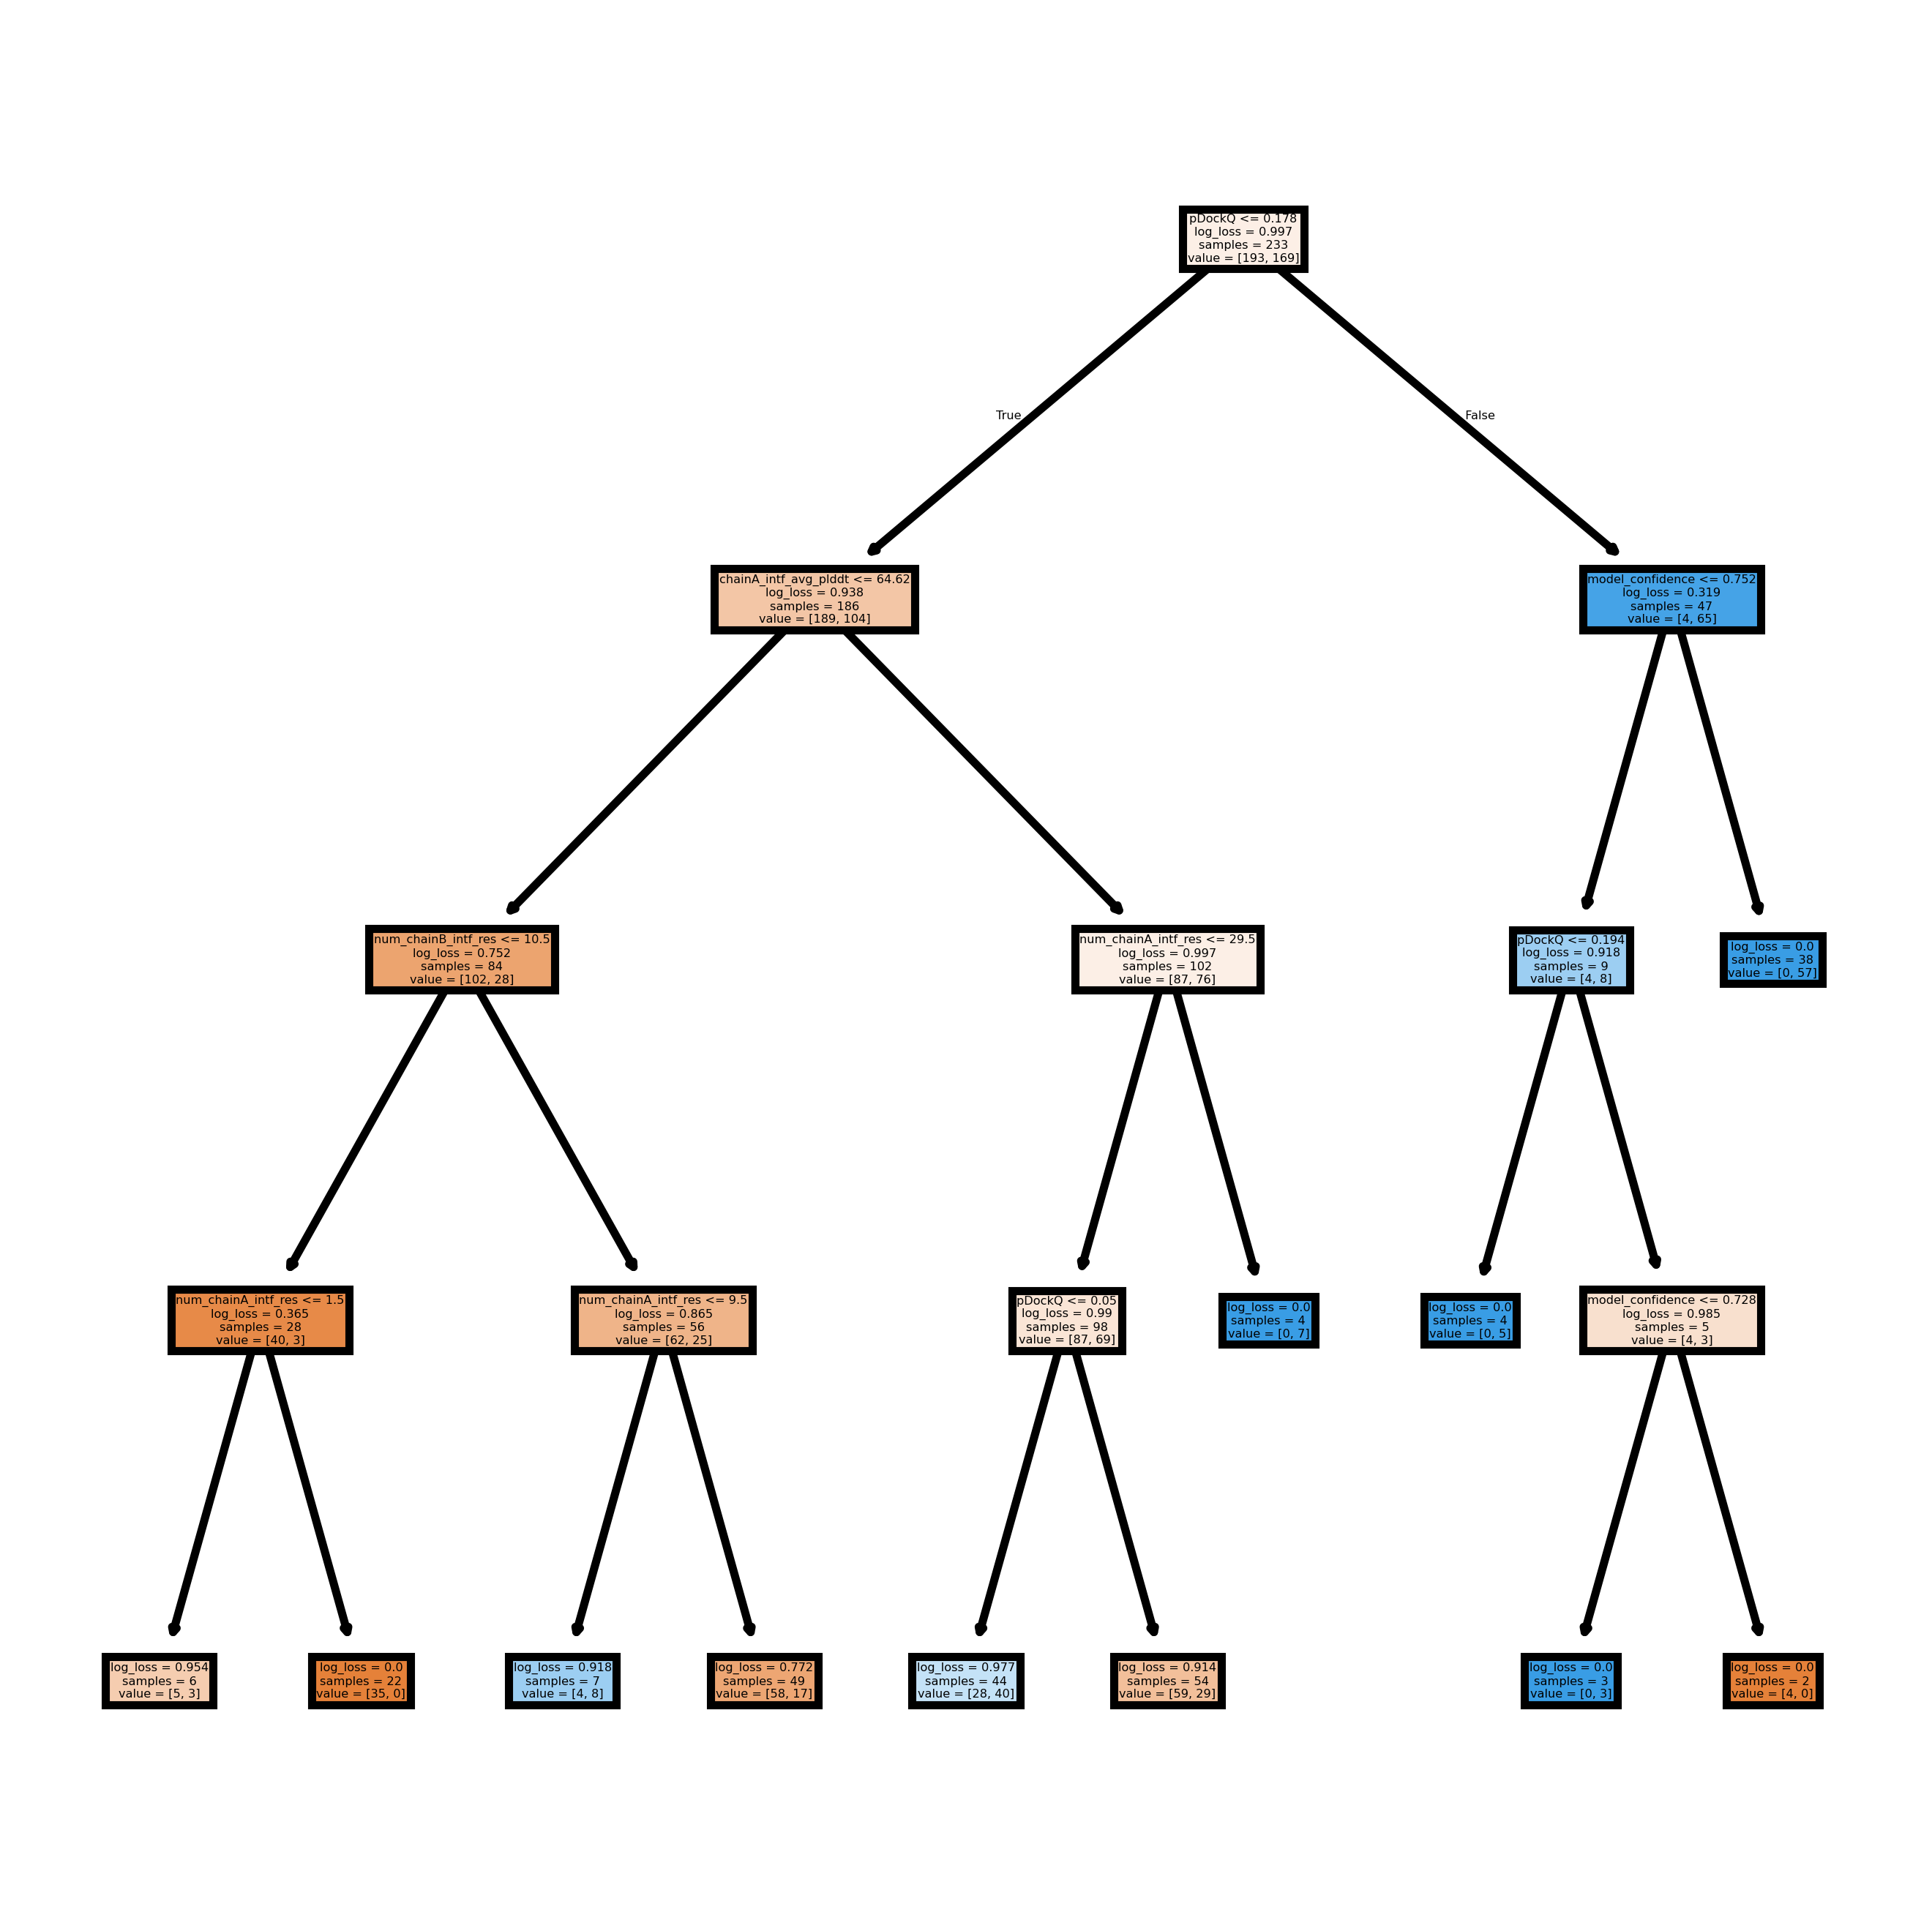

In [145]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
sklearn.tree.plot_tree(rf_best_randomDDI.estimators_[0], feature_names=new_featurenames, filled=True)
plt.show()


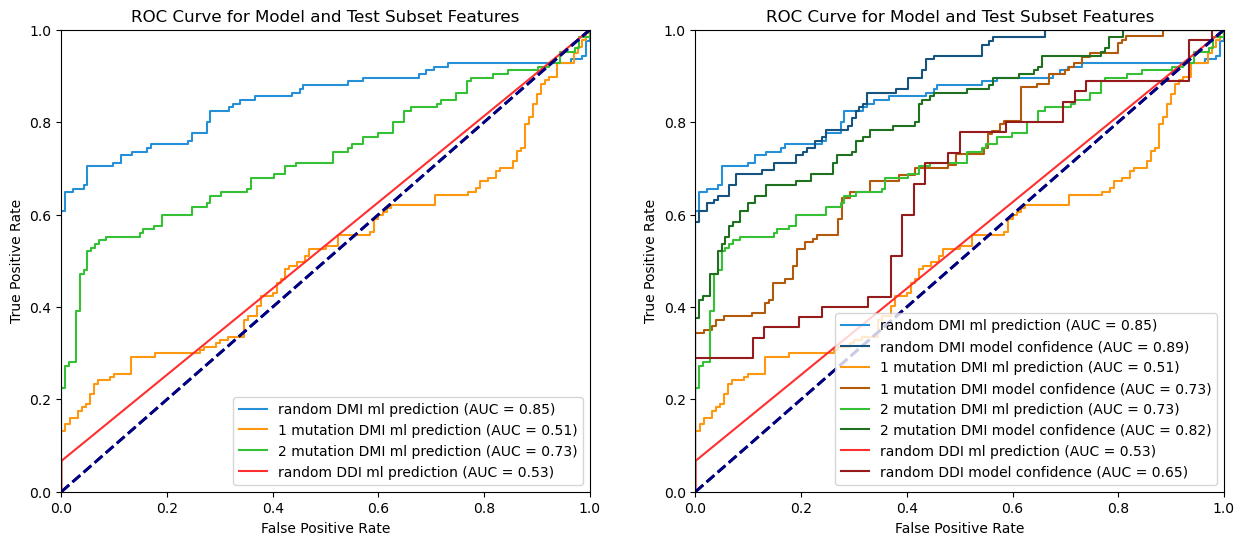

In [137]:
result_array = [
   ("random DMI", rf_best_randomDMI, randomDMI_xy),
   ("1 mutation DMI", rf_best_mutated1DMI, mutated1DMI_xy),
   ("2 mutation DMI", rf_best_mutated2DMI, mutated2DMI_xy),
   ("random DDI", rf_best_randomDDI, newrandomDDI_xy)
]

# Roc Curve
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax1, ax2 = axes
for name, model, xy in result_array:
   y_preda = model.predict_proba(xy[1])
    
   roc_conf_X, roc_conf_Y, _ = roc_curve(xy[3], xy[1]["model_confidence"])
   roc_conf = auc(roc_conf_X, roc_conf_Y)
   roc_model_X, roc_model_Y, _ = roc_curve(xy[3], y_preda[:, 1])
   roc_model = auc(roc_model_X, roc_model_Y)

   _line2D = ax1.plot(roc_model_X, roc_model_Y, label=f"{name} ml prediction (AUC = {roc_model:.2f})")[0]
   c = np.array(colors.to_rgb(_line2D.get_color()))
   c1 = np.clip(1.2*c, a_max=1, a_min=None)
   c2 = 0.7*c
   _line2D.set_color(c1)
   ax2.plot(roc_model_X, roc_model_Y, label=f"{name} ml prediction (AUC = {roc_model:.2f})", color=c1)
   
   ax2.plot(roc_conf_X, roc_conf_Y, label=f"{name} model confidence (AUC = {roc_conf:.2f})", color=c2)
for ax in [ax1, ax2]:   
   ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   ax.set_xlim([0,1])
   ax.set_ylim([0,1])
   ax.set_xlabel('False Positive Rate')
   ax.set_ylabel('True Positive Rate')
   ax.set_title("ROC Curve for Model and Test Subset Features")
   ax.legend(loc="lower right")
plt.show()

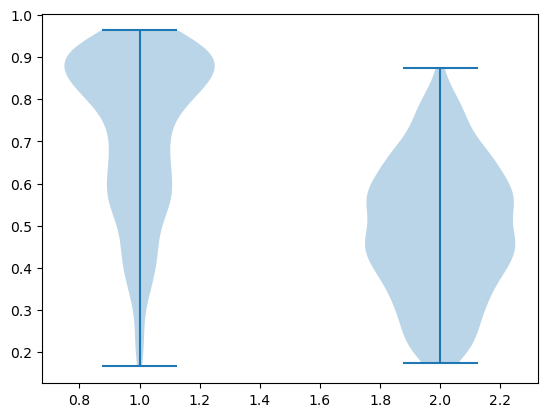

In [150]:
plt.violinplot([dataAF_randomDMI[dataAF_randomDMI["label"] == 1]["model_confidence"], dataAF_randomDMI[dataAF_randomDMI["label"] == 0]["model_confidence"]])
plt.show()